# Classification. Linear models and KNN

In [56]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [58]:
from sklearn.exceptions import NotFittedError

In [59]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        
        return 1/(1 + np.exp(-(np.dot(X, weights))))
    
    def get_loss(self, x, y):
        """Calculate the loss."""
        loss = (np.log(1+np.exp(-np.dot(x, self.weights_)*y))).mean() + 1/(2*self.C)*np.amin((np.linalg.norm(self.weights_))**2)
        #print(loss)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        loss_history = []
        for i in range(self.max_iter):
                      
            delta = - X_ext.T @ (y * (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y)))) / len(y) + (self.weights_ / self.C)
            self.weights_ -= self.eta * delta
            loss_history.append(self.get_loss(X_ext, y))
            if (i == self.max_iter+1) or np.linalg.norm(delta) < self.tol:
                
                break
        return loss_history
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        b = (self.get_sigmoid(X_ext, self.weights_)) > 0.5
        a = b.astype(int)
        final = [-1 if x==0 else x for x in a]
        return final

In [60]:
from sklearn import datasets
from sklearn import metrics

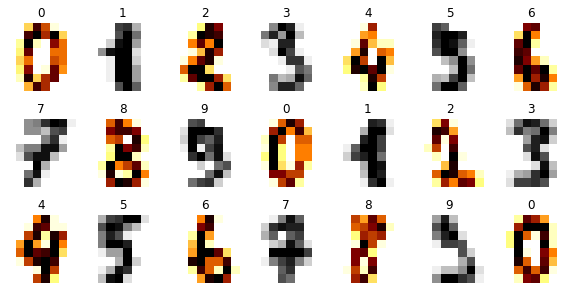

In [61]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [62]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [63]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [64]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [65]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [66]:
lr_clf.fit(X_train, y_train)

[0.6736063862205759]

In [67]:
lr_clf.weights_

array([ 3.13152401e-06,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [68]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [69]:
model = CustomLogisticRegression()

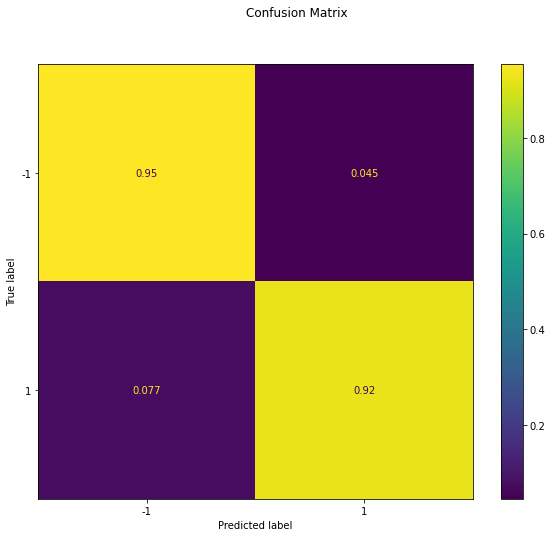

In [70]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [71]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [72]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [73]:
model = CustomLogisticRegression()
kek = model.fit(X_train, y_train)


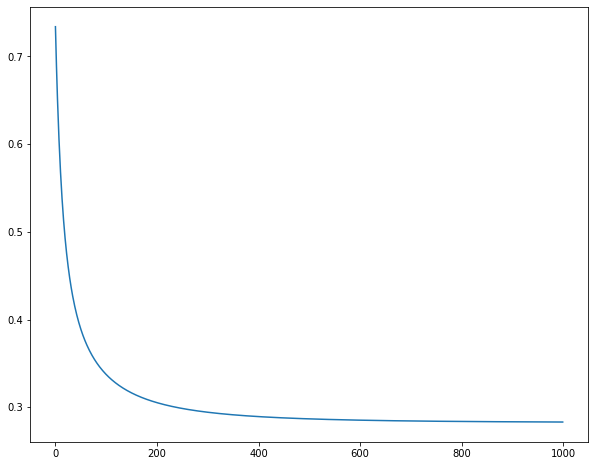

In [74]:
plt.plot(kek)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

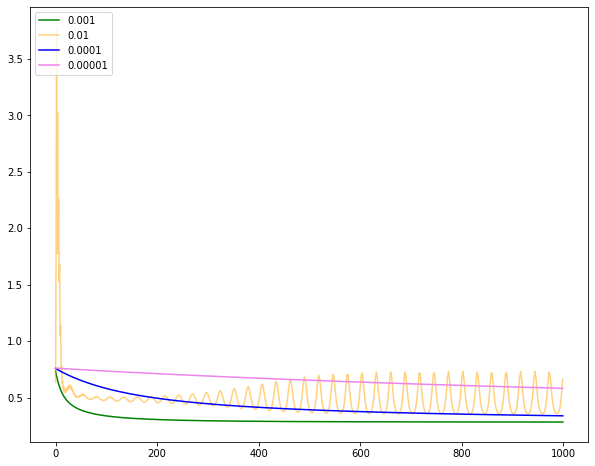

In [75]:
## your code

model2 = CustomLogisticRegression(eta=0.01)
kek2 = model2.fit(X_train, y_train)

model3 = CustomLogisticRegression(eta=0.0001)
kek3 = model3.fit(X_train, y_train)

model4 = CustomLogisticRegression(eta=0.00001)
kek4 = model4.fit(X_train, y_train)

plt.rcParams["figure.figsize"] = (10,8)
fig, ax = plt.subplots()

ax.plot(kek, color = 'green', label = '0.001')
ax.plot(kek2, color = 'orange', alpha = 0.5, label = '0.01')
ax.plot(kek3, color = 'blue', label = '0.0001')
ax.plot(kek4, color = 'violet', label = '0.00001')
ax.legend(loc = 'upper left')
plt.show()

Высокие показатели eta приводят к скачкообразным показаниям потерь, что не есть хорошо. Низкие показатели eta плавные, но показания потерь высокие, что так же не является хорошим результатом. Необходимо искать золотую середину

**(0.5 points)** Try different regularization parameter values and compare the model quality.

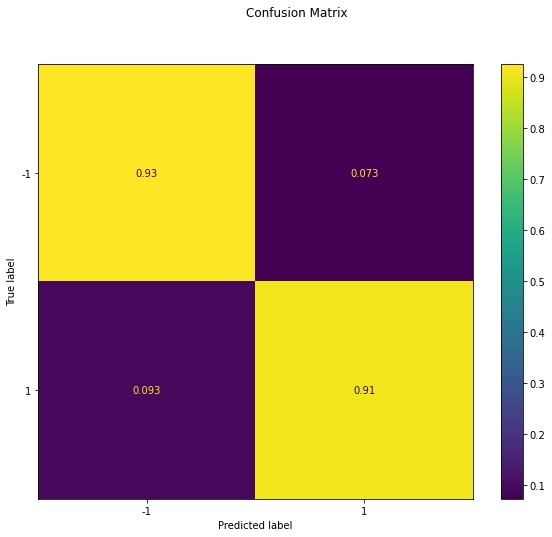

C = 0.3
0.8970076548364648 0.9166666666666666 



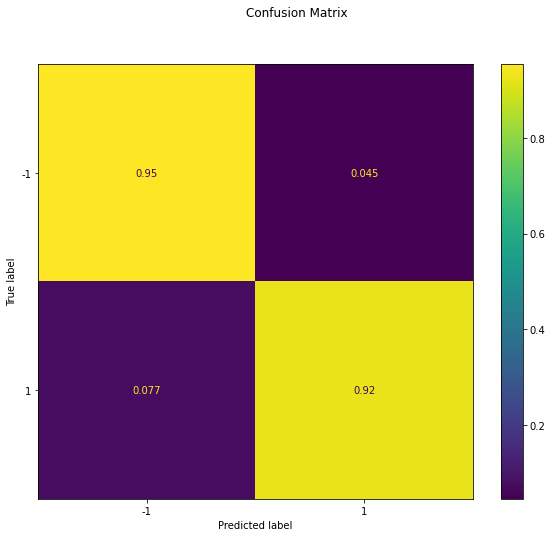

C = 1.0
0.9109255393180237 0.9388888888888889 



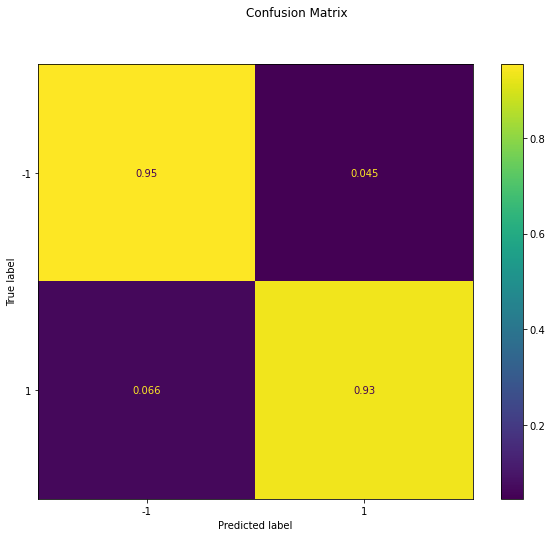

C = 2.0
0.9137091162143354 0.9444444444444444 



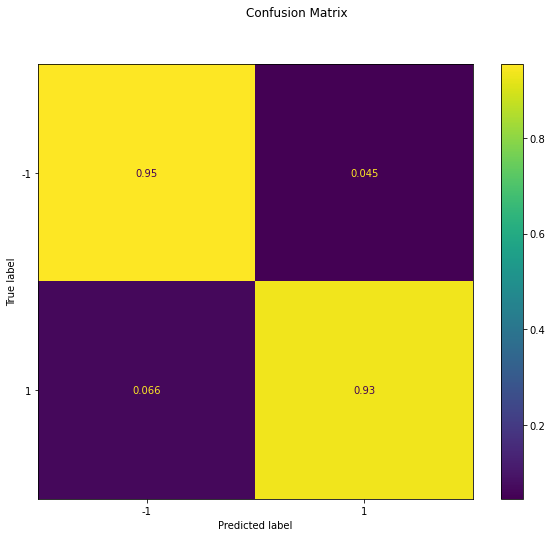

C = 3.0
0.9151009046624913 0.9444444444444444 



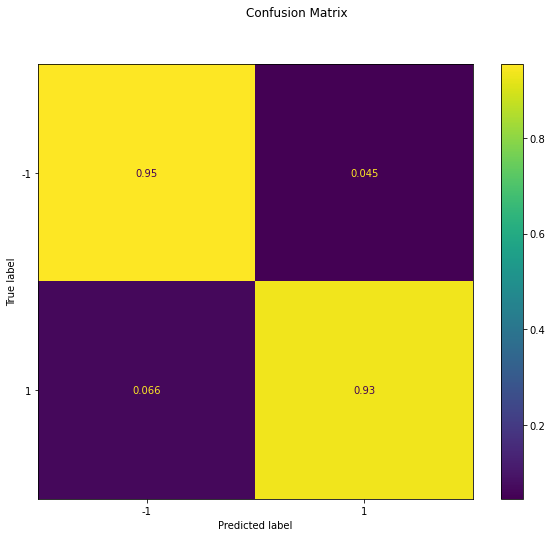

C = 4.0
0.9151009046624913 0.9444444444444444 



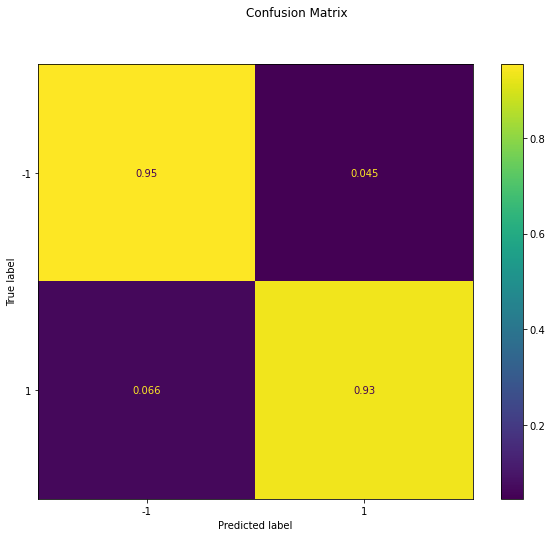

C = 7.0
0.9151009046624913 0.9444444444444444 



In [76]:
reg_params = [0.3, 1.0, 2.0, 3.0, 4.0, 7.0]
for reg_par in reg_params:
    model = CustomLogisticRegression(C=reg_par)
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(f'C = {reg_par}')
    print(train_acc, test_acc,'\n')

При параметре C равном двум и выше accuracy почти и не меняется. Рост с 0 до 1 дает более ощутимый прирост

**(0.5 points)** Compare zero initialization and random initialization. 

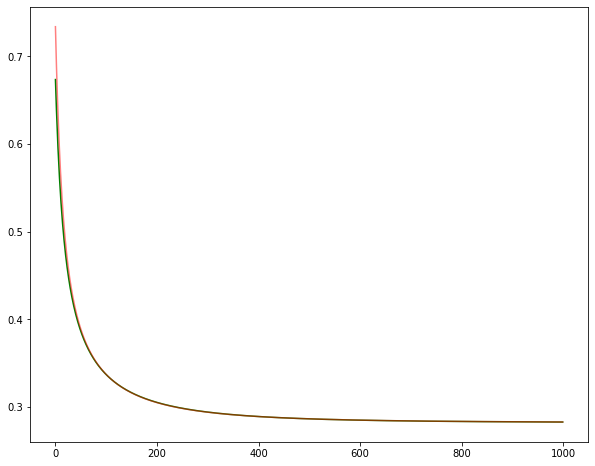

In [77]:
model_zero = CustomLogisticRegression(zero_init=True)
kek = model_zero.fit(X_train, y_train)

model_nonzero = CustomLogisticRegression(zero_init=False)
kek2 = model_nonzero.fit(X_train, y_train)

plt.rcParams["figure.figsize"] = (10,8)
fig, ax = plt.subplots()

ax.plot(kek, color = 'green', label = 'zero init')
ax.plot(kek2, color = 'red', alpha = 0.5, label = 'non zero init')

Нулевая инициализация и ненулевая идиентичны почти на 100 процентов

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [78]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        pass
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        pass
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 'your code'
                
            # <your code>
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        pass

In [79]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [80]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

In [ ]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [ ]:
## your code

< your thoughts >

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [81]:
PATH = "./data/"

In [82]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [83]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [84]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

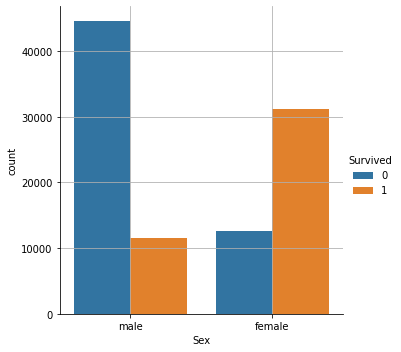

In [85]:
sns.catplot(x='Sex', data=train_data, hue='Survived', kind='count')
plt.grid()

Спасали, как мы видим, больше женщин. Дам вперед

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

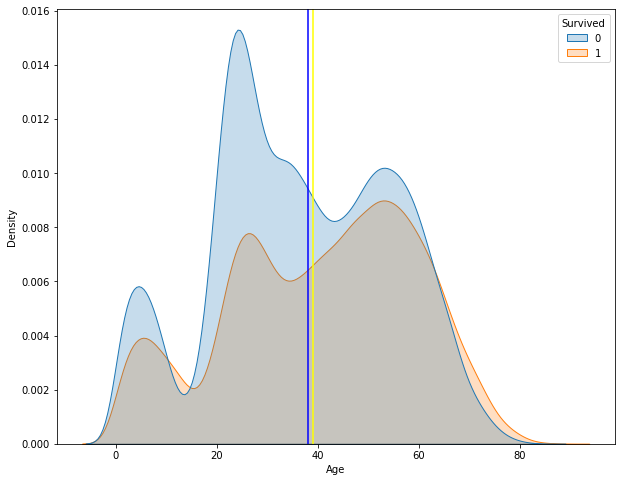

Age survived mean: 40.553799314307795 . median: 43.0
Age deceased mean: 36.70869488153374 . median: 36.0


In [86]:
gr = sns.kdeplot(data=train_data, x='Age', hue='Survived', shade=True)
mean = round(train_data['Age'].mean())
median = train_data['Age'].median()
plt.axvline(mean, c='Blue')
plt.axvline(median, c='Yellow')
plt.show()
age_survived = train_data['Age'].loc[train_data['Survived'] == 1]
age_survived_mean = age_survived.mean()
age_survived_median = age_survived.median()
age_deceased = train_data['Age'].loc[train_data['Survived'] == 0] 
age_deceased_mean = age_deceased.mean()
age_deceased_median = age_deceased.median()
print(f'Age survived mean: {age_survived_mean} . median: {age_survived_median}')
print(f'Age deceased mean: {age_deceased_mean} . median: {age_deceased_median}')

Распределение возрастов среди не/выживших +- схожее. Судя по средней и медиане, спасали более пожилых людей.
Возможно потому что у пожилых более высокий класс билета и больше денег

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

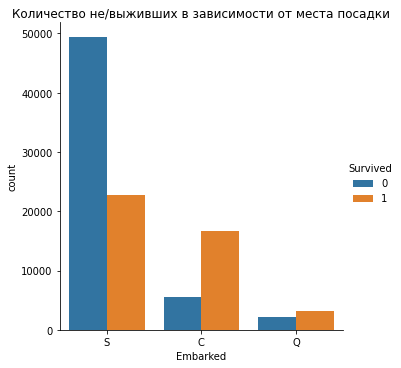

In [87]:
sns.catplot(x='Embarked', data=train_data, hue='Survived', kind='count')
plt.title('Количество не/выживших в зависимости от места посадки')
plt.show()

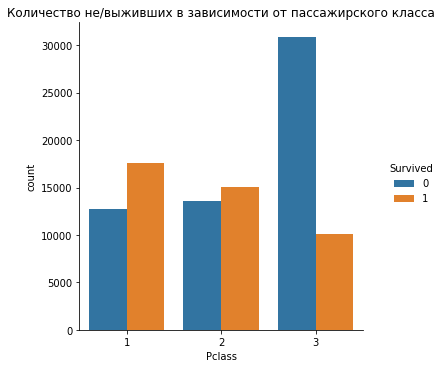

In [88]:
sns.catplot(x='Pclass', data=train_data, hue='Survived', kind='count') 
plt.title('Количество не/выживших в зависимости от пассажирского класса')
plt.show()

Чем выше класс, тем человек элитней, тем больше шанс выжить.
Самый везучий порт посадки это Cherbourg, если брать процентное соотношение

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [89]:
# train data
for col in train_data.columns:
    print('{} - {} %'.format(col, np.mean(train_data[col].isnull()*100)))

PassengerId - 0.0 %
Survived - 0.0 %
Pclass - 0.0 %
Name - 0.0 %
Sex - 0.0 %
Age - 3.292 %
SibSp - 0.0 %
Parch - 0.0 %
Ticket - 4.623 %
Fare - 0.134 %
Cabin - 67.866 %
Embarked - 0.25 %


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Поскольку пропущен малый процент возраста, то мы можем просто посчитать средний возраст всех людей и заполнить этим значением пропуски. Так же можно поступить и с ценой на билет. Если будет работа с кабинами, то удалять столбец нельзя, но если он не будет являться одним из ключевых, то можно даже и удалить его. По поводу плюсов и минусов: минусами будут все эти действия являться, если нам будут нужны на 100% уникальные данные, которые нельзя подделывать. В целом практика заполнения небольших частей данных весьма популярна

In [90]:
# test data
for col in test_data.columns:
    print('{} - {} %'.format(col, np.mean(test_data[col].isnull()*100)))

PassengerId - 0.0 %
Pclass - 0.0 %
Name - 0.0 %
Sex - 0.0 %
Age - 3.487 %
SibSp - 0.0 %
Parch - 0.0 %
Ticket - 5.181 %
Fare - 0.133 %
Cabin - 70.831 %
Embarked - 0.277 %


**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [91]:
# заполняем пропущенные данные
def fill_nan(df):
    
    df_copy = df.copy()
    
    categorical_vars = list(df_copy.select_dtypes(include=['object']).columns.values)
    
    for col in categorical_vars:
        if (df_copy[col].isnull):
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
            
    numerical_vars = list(df_copy.select_dtypes(include=['int64', 'float64']).columns.values)
    
    for col in numerical_vars:
        if (df_copy[col].isnull):
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
            
    return df_copy

In [92]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

train_data['Cabin'] = train_data['Cabin'].fillna("U0")
train_data['Deck'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
train_data['Deck'] = train_data['Deck'].map(deck)
train_data['Deck'] = train_data['Deck'].fillna(0)
train_data['Deck'] = train_data['Deck'].astype(int)

In [93]:
train_data['relatives'] = train_data['SibSp'] + train_data['Parch']
train_data.loc[train_data['relatives'] > 0, 'not_alone'] = 0
train_data.loc[train_data['relatives'] == 0, 'not_alone'] = 1
train_data['not_alone'] = train_data['not_alone'].astype(int)

In [94]:
# Билет, каюту и имя с айди удаляем: они не понадобятся в обучении
cutted = train_data.drop(columns=['Cabin', 'PassengerId', 'Name', 'Ticket'])
train_final = fill_nan(cutted) 
train_final

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,relatives,not_alone
0,1,1,male,39.00,2,0,27.14,S,3,2,0
1,0,3,male,39.00,0,0,13.35,S,8,0,1
2,0,3,male,0.33,1,2,71.29,S,8,3,0
3,0,3,male,19.00,0,0,13.04,S,8,0,1
4,1,3,male,25.00,0,0,7.76,S,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,female,62.00,0,0,14.86,C,4,0,1
99996,0,2,male,66.00,0,0,11.15,S,8,0,1
99997,0,3,male,37.00,0,0,9.95,S,8,0,1
99998,0,3,male,51.00,0,1,30.92,S,8,1,0


In [95]:
test_data['Cabin'] = test_data['Cabin'].fillna("U0")
test_data['Deck'] = test_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
test_data['Deck'] = test_data['Deck'].map(deck)
test_data['Deck'] = test_data['Deck'].fillna(0)
test_data['Deck'] = test_data['Deck'].astype(int)

In [96]:
test_data['relatives'] = test_data['SibSp'] + test_data['Parch']
test_data.loc[test_data['relatives'] > 0, 'not_alone'] = 0
test_data.loc[test_data['relatives'] == 0, 'not_alone'] = 1
test_data['not_alone'] = test_data['not_alone'].astype(int)

In [97]:
# test data

cutted = test_data.drop(columns=['Cabin', 'Name', 'Ticket'])
test_final = fill_nan(cutted) 
test_final

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,relatives,not_alone
0,100000,3,male,19.0,0,0,63.01,S,8,0,1
1,100001,3,female,53.0,0,0,5.81,S,8,0,1
2,100002,1,female,19.0,0,0,38.91,C,2,0,1
3,100003,2,male,25.0,0,0,12.93,S,8,0,1
4,100004,1,female,17.0,0,2,26.89,C,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,female,27.0,0,0,10.12,Q,8,0,1
99996,199996,1,male,59.0,1,0,68.31,S,8,1,0
99997,199997,3,male,47.0,0,0,10.87,S,8,0,1
99998,199998,1,female,49.0,1,2,29.68,C,2,3,0


In [98]:
# незаполненных train данных нет
for col in train_final.columns:
    print('{} - {} %'.format(col, np.mean(train_final[col].isnull()*100)))

Survived - 0.0 %
Pclass - 0.0 %
Sex - 0.0 %
Age - 0.0 %
SibSp - 0.0 %
Parch - 0.0 %
Fare - 0.0 %
Embarked - 0.0 %
Deck - 0.0 %
relatives - 0.0 %
not_alone - 0.0 %


In [99]:
# незаполненных test данных нет
for col in test_final.columns:
    print('{} - {} %'.format(col, np.mean(test_final[col].isnull()*100)))

PassengerId - 0.0 %
Pclass - 0.0 %
Sex - 0.0 %
Age - 0.0 %
SibSp - 0.0 %
Parch - 0.0 %
Fare - 0.0 %
Embarked - 0.0 %
Deck - 0.0 %
relatives - 0.0 %
not_alone - 0.0 %


In [100]:
# теперь надо все данные в int перевести
train_final['Age'] = train_final['Age'].astype(np.int64)

genders = {'male': 0, 'female': 1}
train_final['Sex'] = train_final['Sex'].map(genders)

ports = {"S": 0, "C": 1, "Q": 2}
train_final['Embarked'] = train_final['Embarked'].map(ports)

train_final['Fare'] = train_final['Fare'].astype(np.int64)

train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Survived   100000 non-null  int64
 1   Pclass     100000 non-null  int64
 2   Sex        100000 non-null  int64
 3   Age        100000 non-null  int64
 4   SibSp      100000 non-null  int64
 5   Parch      100000 non-null  int64
 6   Fare       100000 non-null  int64
 7   Embarked   100000 non-null  int64
 8   Deck       100000 non-null  int32
 9   relatives  100000 non-null  int64
 10  not_alone  100000 non-null  int32
dtypes: int32(2), int64(9)
memory usage: 7.6 MB


In [101]:
train_final

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,relatives,not_alone
0,1,1,0,39,2,0,27,0,3,2,0
1,0,3,0,39,0,0,13,0,8,0,1
2,0,3,0,0,1,2,71,0,8,3,0
3,0,3,0,19,0,0,13,0,8,0,1
4,1,3,0,25,0,0,7,0,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,1,62,0,0,14,1,4,0,1
99996,0,2,0,66,0,0,11,0,8,0,1
99997,0,3,0,37,0,0,9,0,8,0,1
99998,0,3,0,51,0,1,30,0,8,1,0


In [102]:
# и для тестовых
test_final['Age'] = test_final['Age'].astype(np.int64)

genders = {'male': 0, 'female': 1}
test_final['Sex'] = test_final['Sex'].map(genders)

ports = {"S": 0, "C": 1, "Q": 2}
test_final['Embarked'] = test_final['Embarked'].map(ports)

test_final['Fare'] = test_final['Fare'].astype(np.int64)

test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   PassengerId  100000 non-null  int64
 1   Pclass       100000 non-null  int64
 2   Sex          100000 non-null  int64
 3   Age          100000 non-null  int64
 4   SibSp        100000 non-null  int64
 5   Parch        100000 non-null  int64
 6   Fare         100000 non-null  int64
 7   Embarked     100000 non-null  int64
 8   Deck         100000 non-null  int32
 9   relatives    100000 non-null  int64
 10  not_alone    100000 non-null  int32
dtypes: int32(2), int64(9)
memory usage: 7.6 MB


In [103]:
test_final

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,relatives,not_alone
0,100000,3,0,19,0,0,63,0,8,0,1
1,100001,3,1,53,0,0,5,0,8,0,1
2,100002,1,1,19,0,0,38,1,2,0,1
3,100003,2,0,25,0,0,12,0,8,0,1
4,100004,1,1,17,0,2,26,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,1,27,0,0,10,2,8,0,1
99996,199996,1,0,59,1,0,68,0,8,1,0
99997,199997,3,0,47,0,0,10,0,8,0,1
99998,199998,1,1,49,1,2,29,1,2,3,0


In [104]:
X_train = train_final.drop('Survived', axis=1)
y_train = train_final['Survived']
x_test = test_final.drop('PassengerId', axis=1)
x_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,relatives,not_alone
0,3,0,19,0,0,63,0,8,0,1
1,3,1,53,0,0,5,0,8,0,1
2,1,1,19,0,0,38,1,2,0,1
3,2,0,25,0,0,12,0,8,0,1
4,1,1,17,0,2,26,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...
99995,3,1,27,0,0,10,2,8,0,1
99996,1,0,59,1,0,68,0,8,1,0
99997,3,0,47,0,0,10,0,8,0,1
99998,1,1,49,1,2,29,1,2,3,0


In [105]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=10000)
log_model.fit(X_train, y_train)
y_pred = log_model.predict(x_test)

acc_log = round(log_model.score(X_train, y_train) * 100, 2)
print(acc_log)

75.8


In [106]:
df_kaggle = pd.DataFrame()
df_kaggle['PassengerId'] = test_final['PassengerId']
df_kaggle['Survived'] = y_pred
df_kaggle.to_csv('kaggle_lin.csv', index=False)

In [107]:
from sklearn.neighbors import KNeighborsClassifier
# KNN 
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(x_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print(acc_knn)

82.22


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [108]:
df_kaggle = pd.DataFrame()
df_kaggle['PassengerId'] = test_final['PassengerId']
df_kaggle['Survived'] = y_pred
df_kaggle.to_csv('kaggle.csv', index=False)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [111]:
kaggle_data = pd.read_csv('kaggle_lin.csv')
kaggle_data

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


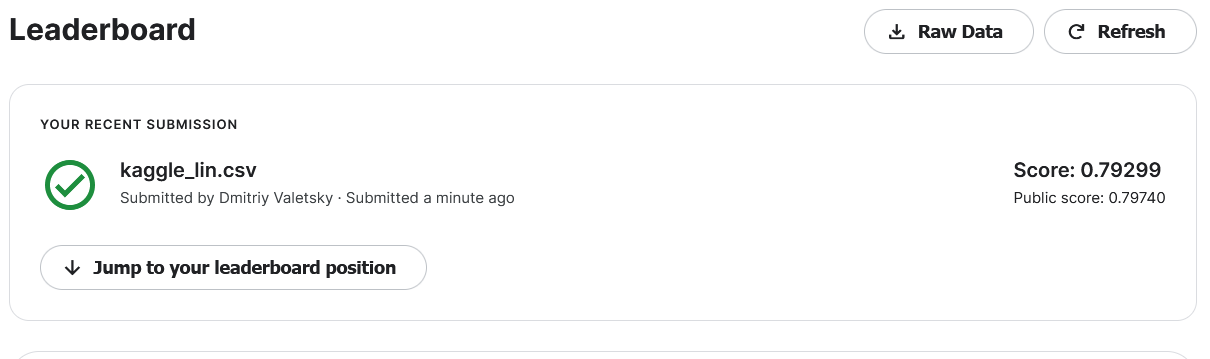

In [110]:
from IPython.display import Image
Image("dimer_score_lin.png")